# packages 

In [1]:
import numpy as np
import pandas as pd
import xarray
import funcs as f
import os

In [2]:
from scipy.interpolate import RectBivariateSpline

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
fs=14
plt.rc("font",size=fs)

### parameters

In [4]:
spacings = {"mynn":333, "ysu":333, "sh":333, "vles":333, "LES":25, "LES_raw":25}

In [5]:
colors = { "LES"   :"k",
          "LES_raw":"k",
          "vles"   :"#808B96",
          "mynn"   :"#641E16",
          "ysu"    :"#A93226",
          "sh"     :"#D98880",}

lss =    { "LES"   :"-",
          "LES_raw":"-",
          "vles"   :"-",
          "mynn"   :"-",
          "ysu"    :"-",
          "sh"     :"-",}

lws =    { "LES"   :2,
          "LES_raw":4,
          "vles"   :2,
          "mynn"   :2,
          "ysu"    :2,
          "sh"     :2}

In [6]:
keys_in_order = ['LES_raw', 'LES', 'vles', 'mynn', 'ysu', 'sh']
sims          = ["LES","vles","mynn","ysu","sh"]
datapath      = "/Volumes/Baby-Orange/XPIA-NCAR/rawest/"
outpath       = "/Volumes/Baby-Orange/XPIA-NCAR/processed/"

### io

In [7]:
days=[20,21,28,29,30]

for iday,day in enumerate(days):
    path = "/Volumes/Baby-Orange/XPIA-NCAR/processed/PBLH_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    tmp = pd.read_csv(path, index_col=[0], parse_dates=True)
    tmp = tmp['median'].copy()
    if iday==0:
        df_zi = tmp.copy()
    else:
        df_zi = pd.concat([df_zi,tmp],axis=0)

In [8]:
z_zi_target = 0.5

In [9]:
convective      = pd.read_csv(os.path.join(outpath,"datetimes_ziL_gt_25.csv"),header=None,index_col=[0])
convective_list = np.array([ pd.Timestamp(l[0]) for l in convective.values.tolist() ])
nt              = len(convective_list)
print(nt)

269


### i/o

In [10]:
varname = 'w'

year    = 2015
month   = 3
day     = 21
hour    = 19
minute  = 50

datetime     = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute)        

print("{0:%Y-%m-%d_%H-%M}".format(datetime))

zi          = df_zi.loc[datetime]

xy_primes, xy_means, k = f.get_prime_and_means(datapath, datetime, zi)            
xy_primes_fine         = f.make_finer(xy_primes)      

2015-03-21_19-50


In [14]:
xy_primes2, xy_means2, k2 = f.get_prime_and_means(datapath, datetime, zi, varname='theta')            
xy_primes_fine2           = f.make_finer(xy_primes2)      

## quick viz

In [11]:
key = "sh"

Text(0.5, 1.0, "2015-03-21 19:50:00\nw'\nk=30")

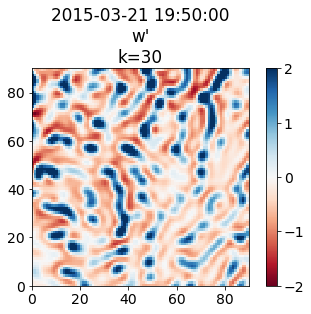

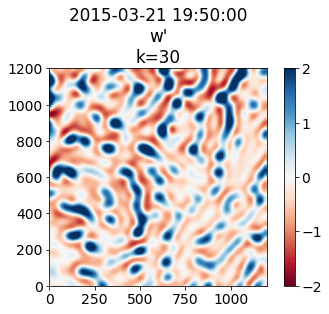

In [12]:
fig = plt.figure()
ax  = fig.add_subplot(111, aspect='equal')
xx = np.linspace(0,30000,90)
# p = ax.pcolormesh(xx,xx,xy_primes[key], vmin=-2, vmax=2, cmap='RdBu')
p = ax.pcolormesh(xy_primes[key], vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar(p)
ax.set_title("{0}\n{1}'\nk={2}".format(datetime, varname, k))
# fig.savefig("../figs/coarse_contours.png", dpi=200,box_inches="tight")

fig = plt.figure()
ax  = fig.add_subplot(111, aspect='equal')
xx = np.linspace(0,30000,1200)
# p = ax.pcolormesh(xx,xx,xy_primes_fine[key], vmin=-2, vmax=2, cmap='RdBu')
p = ax.pcolormesh(xy_primes_fine[key], vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar(p)
ax.set_title("{0}\n{1}'\nk={2}".format(datetime, varname, k))
# fig.savefig("../figs/fine_contours.png", dpi=200,box_inches="tight")

### fft

In [13]:
from scipy import fftpack

In [16]:
array1 = xy_primes[key]
array2 = xy_primes2[key]
spacing = spacings[key]

(npts,npts) = array1.shape

# apply window (to minimize noise since the arrays are not periodic in space)
hamm_2d = f.return_hamming(Nx=npts,Ny=npts)    
array1_windowed = array1 * hamm_2d
array2_windowed = array2 * hamm_2d    

# apply fft
fftarray1  = fftpack.fft2(array1_windowed)
fftarray2  = fftpack.fft2(array2_windowed)    

# get csd
csd_2d   = fftarray1 * fftarray2
csd_2d   = np.abs(csd_2d)**2

# scale the csd when needed
factor = 1#(90/1200)**4 if npts==1200 else 1
csd_2d = csd_2d*factor    

# shift
csd_2d = fftpack.fftshift(csd_2d)    

# get frequencies
frequency = fftpack.fftfreq(npts, d=spacing)
frequency = fftpack.fftshift(frequency)    

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Text(0.5, 1.0, "COARSE\n2015-03-21 19:50:00\nw'\nk=30")

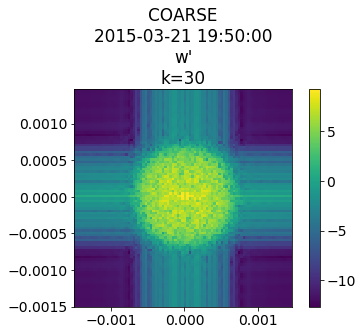

In [18]:
fig = plt.figure()
ax  = fig.add_subplot(111, aspect='equal')
p = ax.pcolormesh(frequency, frequency, np.log10(csd_2d))#, vmin=1, vmax=8)
plt.colorbar(p)
ax.set_title("COARSE\n{0}\n{1}'\nk={2}".format(datetime, varname, k))
# ax.set_xlim([-filterf,filterf])
# ax.set_ylim([-filterf,filterf])
# fig.savefig("../figs/coarse_unscaled.png", dpi=200,box_inches="tight")

In [23]:
array       = xy_primes[key].copy()
(npts,npts) = array.shape
fftarray    = fftpack.fft2(array) 
fftarray    = fftpack.fftshift(fftarray)
psd_coarse  = np.abs(fftarray)**2
spacing     = 333.333333
factor      = 1#90**2
psd_coarse  = psd_coarse*factor #(1/spacing)**2
f_coarse    = fftpack.fftshift(fftpack.fftfreq(npts, d=spacing))

array       = xy_primes_fine[key].copy()
(npts,npts) = array.shape
fftarray    = fftpack.fft2(array)
fftarray    = fftpack.fftshift(fftarray)
psd_fine    = np.abs(fftarray)**2
spacing     = 25.0
factor      = (90/1200)**4#1/90**2#1200**2#(1/90**2) #(90/1200)**2#(1200/90)**2
psd_fine    = psd_fine * factor
f_fine      = fftpack.fftshift(fftpack.fftfreq(npts, d=spacing))

## quick viz

In [24]:
minf    = 1/30000.
maxf    = 1/333.3333
filterf = 1/(2*50)

(-0.01, 0.01)

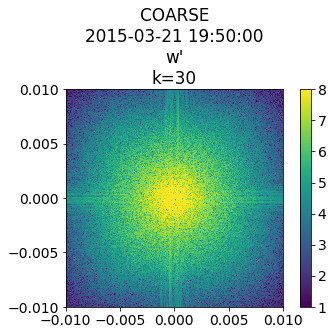

In [25]:
fig = plt.figure()
ax  = fig.add_subplot(111, aspect='equal')
p = ax.pcolormesh(f_coarse, f_coarse, np.log10(psd_coarse), vmin=1, vmax=8)
plt.colorbar(p)
ax.set_title("COARSE\n{0}\n{1}'\nk={2}".format(datetime, varname, k))
ax.set_xlim([-filterf,filterf])
ax.set_ylim([-filterf,filterf])
# fig.savefig("../figs/coarse_unscaled.png", dpi=200,box_inches="tight")


# fig = plt.figure()
# ax  = fig.add_subplot(111, aspect='equal')
# p = ax.pcolormesh(f_fine, f_fine, np.log10(psd_fine), vmin=1, vmax=8)
# plt.colorbar(p)
# ax.set_xlim([-filterf,filterf])
# ax.set_ylim([-filterf,filterf])
# ax.set_title("FINE\n{0}\n{1}'\nk={2}".format(datetime, varname, k))
# fig.savefig("../figs/fine_scaled.png", dpi=200,box_inches="tight")